This notebook serves as a demonstrations for how the affine effective Hamiltonian PMM is used to learn the ground state of the true underlying Hamiltonian

In [1]:
import numpy as np
from scipy.sparse import csr_matrix
import math
import jax.numpy as jnp
from jax import grad, lax, jit
from matplotlib import pyplot as plt

The Hamiltonian considered for this demonstration is the Transverse field Ising model: https://en.wikipedia.org/wiki/Transverse-field_Ising_model
$$H = -J(\sum_{\langle i,j\rangle} Z_iZ_j +g\sum_jX_j)$$


In [2]:
def Pauli(N):
    '''
    N: number of spins
    '''
    sigma = []
    for i in range(N):
        sig = []
        for j in range(3):
            sig.append(csr_matrix((2**N,2**N), dtype=np.complex128).toarray())
        sigma.append(sig)
    #pauli Z
    for nn in range(N):
        for jj in range(2**N):
            d_nn = math.floor(jj/2**nn)%2
            sigma[nn][2][jj][jj] = (-1)**(d_nn)
  #pauli x and y
    for nn in range(N):
        for jj in range(2**N):
            d_nn = math.floor(jj/2**nn)%2
            kk = jj  + (d_nn+1)%2*(2**nn) - d_nn*(2**nn)
            sigma[nn][0][kk][jj] = 1
            sigma[nn][1][kk][jj] = 1j*((-1)**(d_nn))
    return sigma

def Ising(N,J,g):
    '''
    N: number of spins
    J: coupling
    g: transverse field
    H = -J (sum_i sigma_z_i sigma_z_{i+1} + g sum_i sigma_x_i)
    '''
    sigma = Pauli(N)
    HA = csr_matrix((2**N,2**N), dtype=np.complex128)
    HB = csr_matrix((2**N,2**N), dtype=np.complex128)
    for nn in range(N):
            HA = HA + np.matmul(sigma[nn][2], sigma[(nn+1)%N][2]) #sigma z_i sigma z_j
            HB = HB + sigma[nn][0] #sigma x_j
    return -J*(HA + g*HB)

With the transverse field Ising model defined, we begin generating training and test data of the ground state energy $E_0(g)$ as a function of the transverse field strength $g$

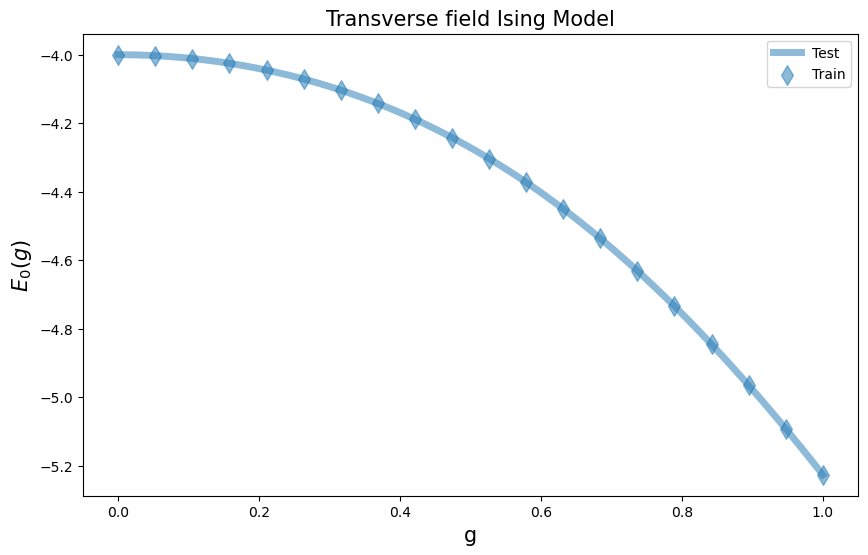

In [3]:
#Generate the data
g_test = np.linspace(0,1,100) #Transverse field strength
g_train = np.linspace(0,1,20)
N = 4 #number of spins
J = 1 #coupling constant

# Compute the ground state energy
E_test = []
for i in g_test:
    H = Ising(N,J,i)
    E_test.append(np.linalg.eigvalsh(H)[0])
E_test = np.array(E_test)
E_train = []
for i in g_train:
    H = Ising(N,J,i)
    E_train.append(np.linalg.eigvalsh(H)[0])
E_train = np.array(E_train)

#Plot the results
plt.figure(figsize=(10,6))
plt.plot(g_test,E_test, lw=5, label = 'Test',alpha = 0.5)
plt.scatter(g_train,E_train, marker='d',s=100, label = 'Train',zorder=10,alpha=0.5)
plt.xlabel(r'g',fontsize=15)
plt.ylabel(r'$E_0(g)$',fontsize=15)
plt.title(r'Transverse field Ising Model',fontsize=15)
plt.legend()
plt.show()

Next we construct the affine effective Hamiltonian PMM

$$M(c) = A + cB$$

Where $c$ is the input parameter/coupling constant. In this example $c=g$.

The PMM is trained with Adam gradient descent method for complex parameters

In [4]:
#complex hermitian matrix
def oH(param,n):
    """
    n: size of nxn matrix
    param: parameter of the matrix
    """
    H = param.reshape(n,n)
    #hermitize the matrix
    H = (H + H.conj().T)/2
    return H

# Construct PMM Hamiltonian
def oM(paramA,paramB,n,c):
    """
    param: parameter of the PMM Hamiltonian
    n: size of nxn PMM matrix
    c: input parameter/couple constant
    M = A + c*B
    """
    return oH(paramA,n) + c*oH(paramB,n)

# Get the eigenvalues of the PMM Hamiltonian
def get_eigen(paramA,paramB,n,C,k):
    """
    k: number of lowest eigenvalues
    """
    def scan_fn(carry, c):
        M = oM(paramA,paramB,n,c) #construct the PMM Hamiltonian
        E_k = jnp.array(jnp.linalg.eigvalsh(M))[:k] #get the k lowest eigenvalues
        return None, E_k
    init = None
    _, y_pred = lax.scan(scan_fn, init, C)
    return y_pred

# Loss function
def Loss(paramA,paramB,C,y_true,n,k):
    """
    y_true: true eigenvalues
    MSE loss
    y_pred: predicted eigenvalues
    y_pred = 1/N*sum_i(y_true_i - y_pred_i)^2
    """
    y_pred = get_eigen(paramA,paramB,n,C,k)
    return jnp.mean((y_true-y_pred)**2) #MSE loss

# Gradient of the loss function
def dLossdx(paramA,paramB,C,y_true,n,k):
    """
    Compute the gradient of the loss function
    """
    return grad(Loss,argnums=(0,1))(paramA,paramB,C,y_true,n,k)

def adam(param,grad,lr,m,v,i):
    """
    Adam optimizer
    lr: learning rate
    m: momentum
    v: velocity
    i: iteration
    """
    rho1 = 0.9 #Adam optimizer hyper-parameter
    rho2 = 0.999 #Adam optimizer hyper-parameter
    eps = 1e-8 #Adam optimizer hyper-parameter
    m = rho1*m + (1-rho1)*grad
    v = rho2*v + (1-rho2)*grad*grad.conj()
    m_hat = m/(1-rho1**(i+1))
    v_hat = v/(1-rho2**(i+1))
    param = param - lr*m_hat/(jnp.sqrt(v_hat)+eps) #update the parameters
    return param,m,v

# Training the model
def train(paramA,paramB,n,C,k,y_true,lr,iterations):
    """
    lr: learning rate
    iterations: number of iterations
    """
    mA = jnp.zeros(paramA.shape,dtype=paramA.dtype) #Adam optimizer momentum for A
    vA = jnp.zeros(paramA.shape,dtype=paramA.dtype) #Adam optimizer velocity for A
    mB = jnp.zeros(paramB.shape,dtype=paramB.dtype) #Adam optimizer momentum for B
    vB = jnp.zeros(paramB.shape,dtype=paramB.dtype) #Adam optimizer velocity for B

    jgrad_ = jit(lambda paramA,paramB, C, y_true: dLossdx(paramA,paramB,C,y_true,n,k))
    low_grad = jgrad_.lower(paramA,paramB, C, y_true)
    jgrad = low_grad.compile()

    jLoss_ = jit(lambda paramA,paramB,C: Loss(paramA,paramB,C,y_true,n,k))
    low_Loss = jLoss_.lower(paramA,paramB,C)
    jLoss = low_Loss.compile()

    i=0
    while i < iterations:
        g = jgrad(paramA,paramB,C,y_true)#gradient of the loss function
        #Adam optimizer update
        paramA,mA,vA = adam(paramA,g[0].conj(),lr,mA,vA,i)
        paramB,mB,vB = adam(paramB,g[1].conj(),lr,mB,vB,i)
        #print loss every 100 iterations
        if i%500 == 0:
            print(f'Iter:{i} Loss =',jLoss(paramA,paramB,C))
        i += 1
    return paramA,paramB

#predict function
def predict(paramA,paramB,n,C,k):
    return get_eigen(paramA,paramB,n,C,k)

With the PMM defined, we can begin training the model my minimizing the Mean Squared Error between the true ground state and the predicted ground stae

In [5]:
#initialize the PMM parameters
n = 4 #size of nxn PMM
X_train = jnp.array(g_train).reshape(-1,1) #input
y_train = jnp.array(E_train).reshape(-1,1) #output
k = 1 #number of lowest eigenvalues to predict
paramA = np.random.randn(n**2) + 1j*np.random.randn(n**2)  #initialize the parameters
paramB = np.random.randn(n**2) + 1j*np.random.randn(n**2)  #initialize the parameters
lr = 0.01 #learning rate
iterations = 5000 #number of training iterations

#train the model
result = train(jnp.array(paramA),jnp.array(paramB),n,X_train,k,y_train,lr,iterations)

Iter:0 Loss = 2.8017025
Iter:500 Loss = 0.0029160534
Iter:1000 Loss = 0.0006972972
Iter:1500 Loss = 4.0649065e-05
Iter:2000 Loss = 2.6154014e-06
Iter:2500 Loss = 2.0092152e-06
Iter:3000 Loss = 1.7779572e-06
Iter:3500 Loss = 1.5231813e-06
Iter:4000 Loss = 1.2574568e-06
Iter:4500 Loss = 9.999887e-07


Finaly we use the trained PMM parameters to make a prediction on unseen data

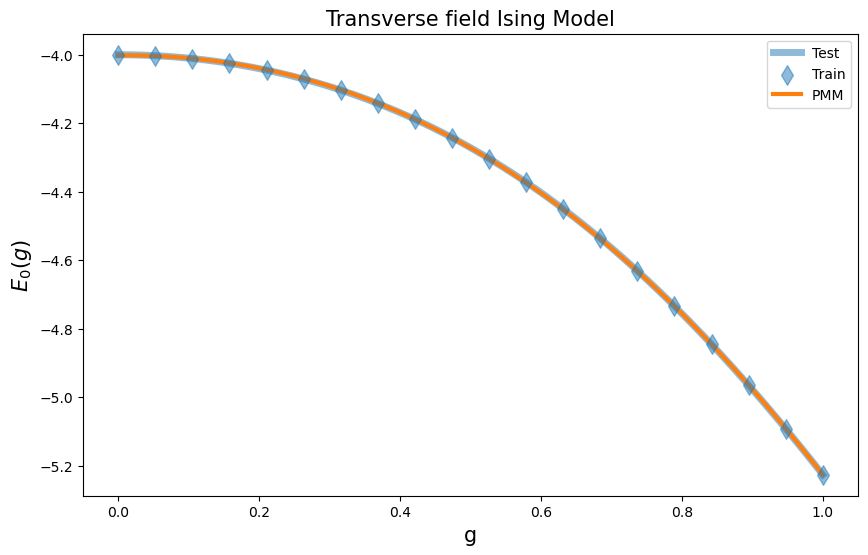

In [6]:
#make prediction
X_test = jnp.array(g_test).reshape(-1,1)
y_test = jnp.array(E_test).reshape(-1,1)
y_pred = predict(result[0],result[1],n,X_test,k)

#plot figure
plt.figure(figsize=(10,6))
plt.plot(g_test,y_test,lw =5, label = 'Test',alpha = 0.5)
plt.scatter(g_train,y_train,marker='d',s=100, label = 'Train',zorder=10,alpha=0.5)
plt.plot(g_test,y_pred,lw=3, label = 'PMM')
plt.xlabel(r'g',fontsize=15)
plt.ylabel(r'$E_0(g)$',fontsize=15)
plt.title(r'Transverse field Ising Model',fontsize=15)
plt.legend()
plt.show()